## **Big Data Technology Project :  Identifying Top Destinations Using Flight Data and Apache Spark**

Contributors:

+ ITDSIU21001 - Phan Quốc Anh -

+ ITDSIU21067 - Nguyễn Quốc Huy -

# **Import data using Kaggle** #

Get Your Kaggle API Key

- Log in to your Kaggle account.
- Go to Account Settings (you'll need to be logged in).
- Scroll to the API section and click Create New API Token.
  - This will download a file named kaggle.json to your computer.

Upload kaggle.json to Colab

In [ ]:
from google.colab import files
files.upload()  # Select the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aaronphan18","key":"4e67898ebaddee3ebc45085bb89b6cc3"}'}

Configure Kaggle API

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [ ]:
!kaggle datasets list


ref                                                                    title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset                    Customer Shopping (Latest Trends) Dataset            76KB  2024-11-23 15:26:12          14255        276  1.0              
hopesb/student-depression-dataset                                      Student Depression Dataset.                         454KB  2024-11-22 17:56:03          10970        142  1.0              
chadwambles/supermarket-sales                                          SuperMarket Sales                                    36KB  2024-12-17 23:35:52           1346         26  0.88235295       
adarsh0806/influencer-mer

Download the Dataset

In [ ]:
!kaggle datasets download -d patrickzel/flight-delay-and-cancellation-dataset-2019-2023


Dataset URL: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023
License(s): other
 97% 136M/140M [00:03<00:00, 72.2MB/s]
100% 140M/140M [00:03<00:00, 48.3MB/s]


In [ ]:
!unzip flight-delay-and-cancellation-dataset-2019-2023.zip


Archive:  flight-delay-and-cancellation-dataset-2019-2023.zip
  inflating: dictionary.html         
  inflating: flights_sample_3m.csv   


#**Visualization**

In [ ]:
from pyspark.sql.functions import concat_ws, lit

# Tạo cột mới 'ROUTE' bằng cách kết hợp ORIGIN và DEST với định dạng "JFK -> LAX"
df_with_route = flights_cleaned.withColumn("ROUTE", concat_ws(" -> ", flights_cleaned["ORIGIN"], flights_cleaned["DEST"]))

# Hiển thị kết quả
df_with_route.show(10)

+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+--------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+----------+-----+----+----------+-------------+---------+------------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|           DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|     ROUTE|Month|Year|IS_DELAYED|FLIGHT_STATUS|TAXI_TIME|ELAPSED_TIME_DISCREPAN

<ipython-input-36-b1628b11c476>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="ROUTE", data=top_routes, palette="viridis")


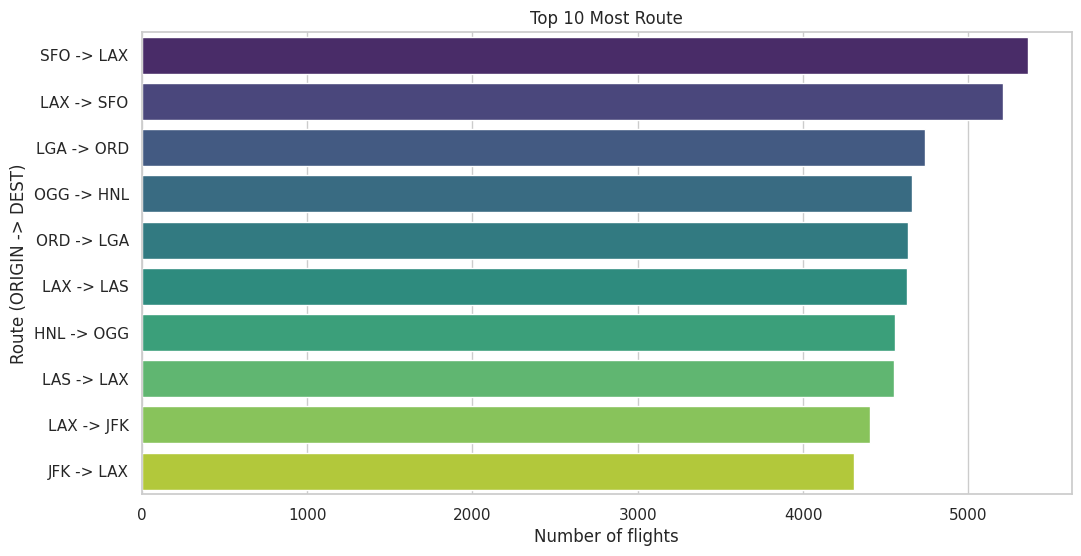

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển DataFrame từ PySpark sang Pandas
route_df = df_with_route.groupBy("ROUTE").count().toPandas()

# Sắp xếp và lấy ra các tuyến đường phổ biến nhất
top_routes = route_df.sort_values(by="count", ascending=False).head(10)

# Vẽ biểu đồ Bar thể hiện các tuyến đường phổ biến nhất
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="ROUTE", data=top_routes, palette="viridis")
plt.title("Top 10 Most Route")
plt.xlabel("Number of flights")
plt.ylabel("Route (ORIGIN -> DEST)")
plt.show()

In [ ]:
from pyspark.sql.functions import to_date, month, year, dayofweek, quarter

# Chuyển FL_DATE thành kiểu date và trích xuất các giá trị
df = flights_cleaned.withColumn("FL_DATE", to_date("FL_DATE", "yyyy-MM-dd")) \
       .withColumn("Year", year("FL_DATE")) \
       .withColumn("Month", month("FL_DATE")) \
       .withColumn("Day_of_Week", dayofweek("FL_DATE")) \
       .withColumn("Quarter", quarter("FL_DATE"))

In [ ]:
df.createOrReplaceTempView("flights")

# Tần suất các điểm đến theo tháng
result = spark.sql("""
    SELECT DEST, Month, COUNT(*) AS flight_count
    FROM flights
    GROUP BY DEST, Month
    ORDER BY flight_count DESC
""")
result.show()

+----+-----+------------+
|DEST|Month|flight_count|
+----+-----+------------+
| ATL|    3|       15212|
| ATL|    7|       14433|
| ATL|    8|       14268|
| ATL|    1|       14127|
| ATL|    5|       12996|
| ATL|    6|       12928|
| ATL|    2|       12913|
| ATL|    4|       12737|
| DFW|    7|       12573|
| DFW|    8|       12514|
| ORD|    8|       12413|
| DFW|    3|       12077|
| DEN|    8|       12043|
| ORD|    7|       11856|
| DFW|    6|       11802|
| DEN|    7|       11716|
| ORD|    3|       11611|
| DFW|    5|       11290|
| DFW|    1|       11248|
| ATL|   10|       11174|
+----+-----+------------+
only showing top 20 rows



In [ ]:
# Tạo cột Quarter dựa trên Month
import pandas as pd

# Assuming 'result' from the previous cell is a PySpark DataFrame
pandas_df = result.toPandas()  # Convert PySpark DataFrame to Pandas DataFrame

pandas_df["Quarter"] = pd.cut(
    pandas_df["Month"],
    bins=[0, 3, 6, 9, 12],
    labels=["Q1", "Q2", "Q3", "Q4"]
)

In [ ]:
quarterly_data = pandas_df.groupby(["Quarter", "DEST"])["flight_count"].sum().reset_index()


<ipython-input-44-ff0a688d0a78>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quarterly_data = pandas_df.groupby(["Quarter", "DEST"])["flight_count"].sum().reset_index()


<ipython-input-46-277c4446a5d4>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=quarterly_data, x="Quarter", y="flight_count", ci=None)


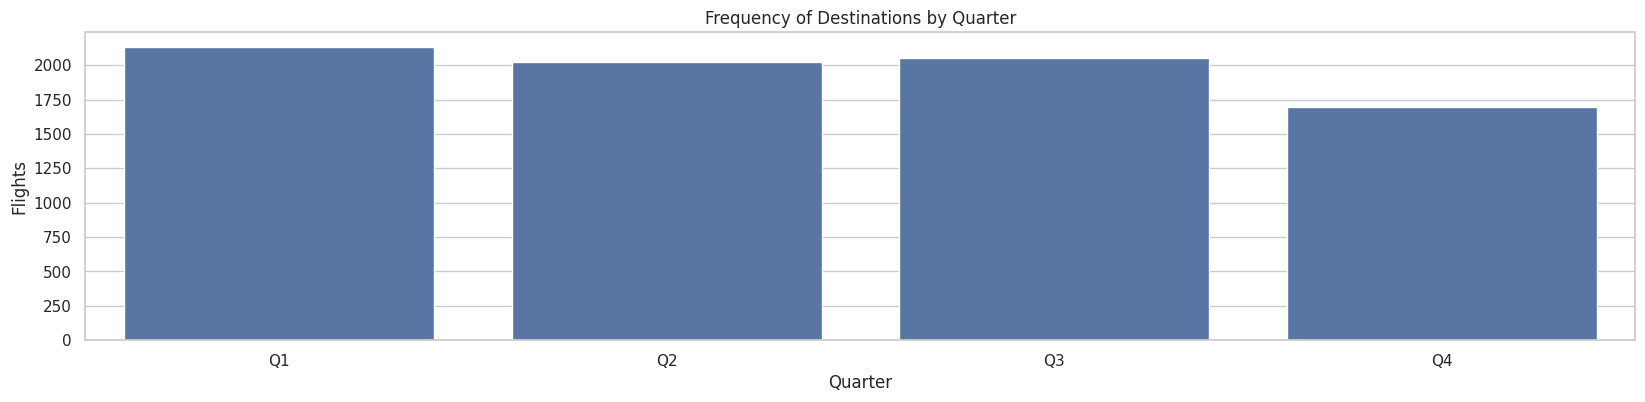

In [ ]:
# Vẽ biểu đồ cột thể hiện tần suất điểm đến theo quý
plt.figure(figsize=(20, 4))
sns.barplot(data=quarterly_data, x="Quarter", y="flight_count", ci=None)
plt.title("Frequency of Destinations by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Flights")
plt.show()

In [ ]:
result_quarter = spark.sql("""
    SELECT DEST, Quarter, COUNT(*) AS flight_count
    FROM flights
    GROUP BY DEST, Quarter
    ORDER BY flight_count DESC
""")
result_quarter.show()

+----+-------+------------+
|DEST|Quarter|flight_count|
+----+-------+------------+
| ATL|      1|       42252|
| ATL|      3|       39490|
| ATL|      2|       38661|
| DFW|      3|       34410|
| DFW|      2|       33821|
| DFW|      1|       33710|
| ORD|      3|       33381|
| ATL|      4|       33166|
| ORD|      1|       32530|
| DEN|      3|       32460|
| ORD|      2|       30933|
| DEN|      1|       30785|
| DEN|      2|       30452|
| DFW|      4|       27829|
| ORD|      4|       26490|
| DEN|      4|       25895|
| CLT|      1|       25574|
| CLT|      2|       24579|
| CLT|      3|       24497|
| LAX|      1|       23104|
+----+-------+------------+
only showing top 20 rows



In [ ]:
import pandas as pd

# Đọc dữ liệu từ CSV
df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')

# Loại bỏ các cột không cần thiết
df_airports = df_airports.drop(columns=["airport", "city", "state", "country", "cnt"])

# Hiển thị kết quả
print(df_airports)

    iata        lat        long
0    ORD  41.979595  -87.904464
1    ATL  33.640444  -84.426944
2    DFW  32.895951  -97.037200
3    PHX  33.434167 -112.008056
4    DEN  39.858408 -104.667002
..   ...        ...         ...
216  EAU  44.865257  -91.485072
217  DBQ  42.402959  -90.709167
218  RST  43.908826  -92.497987
219  UTM  34.681499  -90.348816
220  BIL  45.807662 -108.542861

[221 rows x 3 columns]


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Đọc dữ liệu sân bay và dữ liệu các chuyến bay
df_airports = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')
df_flight_paths = pd.read_csv('flights_sample_3m.csv')

# Tạo từ điển chứa tọa độ của các sân bay
airport_coords = df_airports.set_index('airport')[['lat', 'long']].to_dict('index')

# Tạo hình vẽ
fig = go.Figure()

# Thêm các sân bay vào bản đồ
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_airports['long'],
    lat = df_airports['lat'],
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

# Vẽ các chuyến bay giữa các sân bay
for i in range(len(df_flight_paths)):
    origin = df_flight_paths['ORIGIN'][i]
    dest = df_flight_paths['DEST'][i]

    # Lấy tọa độ của ORIGIN và DEST từ airport_coords
    if origin in airport_coords and dest in airport_coords:
        origin_coords = airport_coords[origin]
        dest_coords = airport_coords[dest]

        # Thêm đường bay vào bản đồ
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [origin_coords['long'], dest_coords['long']],
                lat = [origin_coords['lat'], dest_coords['lat']],
                mode = 'lines',
                line = dict(width = 1, color = 'red'),
                opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
            )
        )

# Cập nhật layout và hiển thị bản đồ
fig.update_layout(
    title_text = ' American Airport <br>(Hover for airport names)',
    showlegend = False,
    geo = dict(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()


In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Bước 1: Đọc dữ liệu chuyến bay và thông tin sân bay
# Dữ liệu chuyến bay (giả sử đã có cột DEST)
flights_data = pd.read_csv("flights_sample_3m.csv")

# Dữ liệu tọa độ các sân bay (bao gồm mã sân bay, latitude, longitude)
airports_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')

# Bước 2: Tổng hợp số lượng chuyến bay theo DEST
flight_counts = flights_data.groupby("DEST").size().reset_index(name="count")

# Ghép dữ liệu chuyến bay với tọa độ sân bay
merged_data = flight_counts.merge(
    airports_data, left_on="DEST", right_on="iata", how="inner"
)

# Lọc ra dữ liệu cần cho heatmap
heatmap_data = merged_data[["lat", "long", "count"]].values.tolist()

# Bước 3: Tạo bản đồ heatmap
# Khởi tạo bản đồ tại trung tâm nước Mỹ
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Thêm lớp heatmap
HeatMap(heatmap_data).add_to(m)

# Lưu bản đồ ra file HTML
# m.save("us_flight_heatmap.html")

# Hiển thị bản đồ nếu chạy trong Jupyter Notebook
m


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import datetime, warnings, scipy
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv("flights_sample_3m.csv")

df.head(5)
df['FL_DATE'] =  pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d')

In [ ]:
df = df.drop(df[df.CANCELLED == True].index)
df = df.drop(df[df.DIVERTED == True].index)

In [ ]:
# Calculate the proportion of missing data

def checkMissing(data,perc=0):
    """
    Takes in a dataframe and returns
    the percentage of missing value.
    """
    missing = [(i, data[i].isna().mean()*100) for i in data]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > perc]
    print(missing.sort_values("percentage", ascending=False).reset_index(drop=True))

print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
                column_name  percentage
0         CANCELLATION_CODE  100.000000
1         DELAY_DUE_CARRIER   81.678143
2         DELAY_DUE_WEATHER   81.678143
3             DELAY_DUE_NAS   81.678143
4        DELAY_DUE_SECURITY   81.678143
5   DELAY_DUE_LATE_AIRCRAFT   81.678143
6                 WHEELS_ON    0.000069
7                   TAXI_IN    0.000069
8                  ARR_TIME    0.000069
9                 ARR_DELAY    0.000069
10             ELAPSED_TIME    0.000069
11                 AIR_TIME    0.000069


In [ ]:
# Drop columns with high missing values
columns_to_drop = ['CANCELLATION_CODE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER',
                   'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
df = df.drop(columns=columns_to_drop)

# Drop rows with missing values for columns with low missing values
df = df.dropna(subset=['WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'ELAPSED_TIME', 'AIR_TIME'])

In [ ]:
import datetime
import numpy as np

# Function that converts the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == '2400':
            chaine = '0000'
        chaine = "{0:04d}".format(int(chaine))
        # Extract hour and minute parts
        hour = int(chaine[0:2])
        minute = int(chaine[2:4])
        # Handle the special case where hour is 24
        if hour == 24:
            hour = 0
        # Return datetime.time object
        heure = datetime.time(hour, minute)
        return heure

# Apply the function to the desired columns
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

# Apply the function to 'WheelsOff' and 'WheelsOn' columns as well
df['WHEELS_OFF'] = df['WHEELS_OFF'].apply(format_heure)
df['WHEELS_ON'] = df['WHEELS_ON'].apply(format_heure)

In [ ]:
df[['DEP_TIME','CRS_DEP_TIME','ARR_TIME','WHEELS_OFF','WHEELS_ON']].head(5)


,DEP_TIME,CRS_DEP_TIME,ARR_TIME,WHEELS_OFF,WHEELS_ON
0,11:51:00,11:55:00,14:47:00,12:10:00,14:43:00
1,21:14:00,21:20:00,23:10:00,21:23:00,22:32:00
2,10:00:00,09:54:00,12:52:00,10:20:00,12:47:00
3,16:08:00,16:09:00,18:53:00,16:35:00,18:44:00
4,18:38:00,18:40:00,20:40:00,18:53:00,20:26:00


In [ ]:
df[['DEP_TIME','CRS_DEP_TIME','ARR_TIME','WHEELS_OFF','WHEELS_ON']].info()


<class 'pandas.core.frame.DataFrame'>
Index: 2913802 entries, 0 to 2999999
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   DEP_TIME      object
 1   CRS_DEP_TIME  object
 2   ARR_TIME      object
 3   WHEELS_OFF    object
 4   WHEELS_ON     object
dtypes: object(5)
memory usage: 133.4+ MB


In [ ]:
import pandas as pd

# Function to calculate time difference in minutes
def time_difference(actual, plan):
    try:
        actual_time = pd.to_datetime(actual, format='%H:%M:%S')
        plan_time = pd.to_datetime(plan, format='%H:%M:%S')
        time_diff = (actual_time - plan_time).dt.total_seconds() / 60
        return time_diff
    except ValueError:
        return None  # Handle NaN values or invalid time formats gracefully

# Apply the function and filter out incorrect records
df['WHEELS_OFF_elapse'] = time_difference(df['WHEELS_OFF'], df['DEP_TIME'])
df['WHEELS_ON_elapse'] = time_difference(df['ARR_TIME'], df['WHEELS_ON'])

# Remove records where time difference is negative or NaN
df = df.dropna(subset=['WHEELS_OFF_elapse', 'WHEELS_ON_elapse'])
df = df[(df['WHEELS_OFF_elapse'] > 0) & (df['WHEELS_ON_elapse'] > 0)]

In [ ]:
df.AIRLINE.value_counts()

,count
AIRLINE,
Southwest Airlines Co.,553883
Delta Air Lines Inc.,385512
American Airlines Inc.,368069
SkyWest Airlines Inc.,334080
United Air Lines Inc.,245774
Republic Airline,137684
Envoy Air,117015
Endeavor Air Inc.,109623
JetBlue Airways,107798


In [ ]:
df.DEST.value_counts().iloc[:6]


,count
DEST,
ATL,150028
DFW,124601
ORD,118099
DEN,115371
CLT,92382
LAX,83331


In [ ]:
top_cities = df.DEST.value_counts().iloc[0:6].rename_axis('DEST').reset_index(name='TOTAL_FLIGHTS')
top_cities.head()

,DEST,TOTAL_FLIGHTS
0,ATL,150028
1,DFW,124601
2,ORD,118099
3,DEN,115371
4,CLT,92382


In [ ]:
# Checking the cities within the numpy array just to verify that it worked
top_cities.DEST.unique()

# Creating a list with top cities only:
city_list = top_cities['DEST'].tolist()

In [ ]:
boolean_series =  df.DEST.isin(city_list)
df =  df[boolean_series]
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_OFF_elapse,WHEELS_ON_elapse
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",18:40:00,18:38:00,-2.0,15.0,18:53:00,20:26:00,14.0,2041,20:40:00,-1.0,0.0,0.0,181.0,182.0,153.0,985.0,15.0,14.0
8,2023-02-12,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,590,IAH,"Houston, TX",LAX,"Los Angeles, CA",05:30:00,05:27:00,-3.0,11.0,05:38:00,06:58:00,8.0,717,07:06:00,-11.0,0.0,0.0,227.0,219.0,200.0,1379.0,11.0,8.0
11,2020-07-31,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2107,RDU,"Raleigh/Durham, NC",DFW,"Dallas/Fort Worth, TX",12:07:00,12:01:00,-6.0,14.0,12:15:00,13:46:00,11.0,1358,13:57:00,-1.0,0.0,0.0,171.0,176.0,151.0,1061.0,14.0,11.0
13,2019-11-20,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1065,BDL,"Hartford, CT",ATL,"Atlanta, GA",06:00:00,05:55:00,-5.0,15.0,06:10:00,08:02:00,6.0,840,08:08:00,-32.0,0.0,0.0,160.0,133.0,112.0,859.0,15.0,6.0
16,2020-07-01,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1225,STT,"Charlotte Amalie, VI",ATL,"Atlanta, GA",16:15:00,16:13:00,-2.0,15.0,16:28:00,19:45:00,3.0,1957,19:48:00,-9.0,0.0,0.0,222.0,215.0,197.0,1599.0,15.0,3.0


ARR_DELAY

In [ ]:
status = []

for value in df['ARR_DELAY']:
    if value <= 10:
        status.append(0)
    else:
        status.append(1)
df['FLIGHT_STATUS'] = status

In [ ]:
df_category = df.select_dtypes(include=['object','category'])
df_numerical = df.select_dtypes(exclude=['object'])

[Text(0.5, 0, 'Number of counts')]

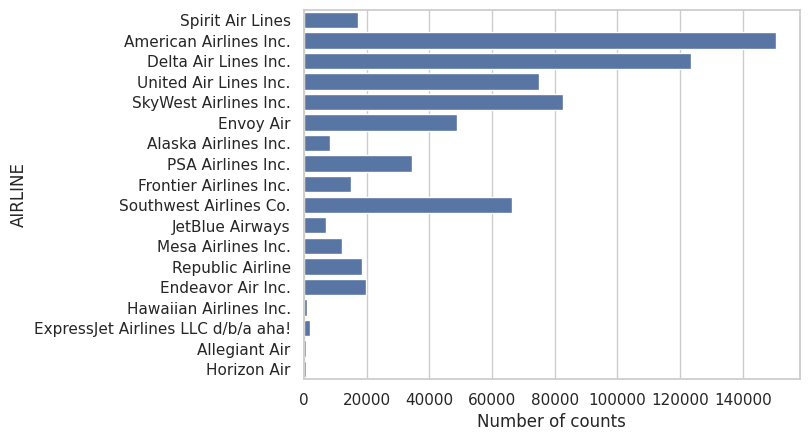

In [ ]:
# Output Barplot showing the occurence of each categorical features
sb.set_context("notebook")
g=sb.countplot(y="AIRLINE",data=df_category)
g.set(xlabel="Number of counts")

[Text(0.5, 0, 'Number of counts')]

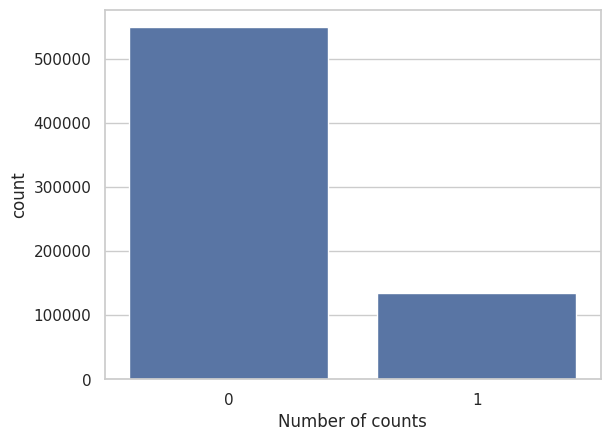

In [ ]:
# Output Barplot showing the occurence of flight outcome

sb.set_context("notebook")
g=sb.countplot(x="FLIGHT_STATUS",data=df)
g.set(xlabel="Number of counts")

[Text(0.5, 0, 'Number of counts')]

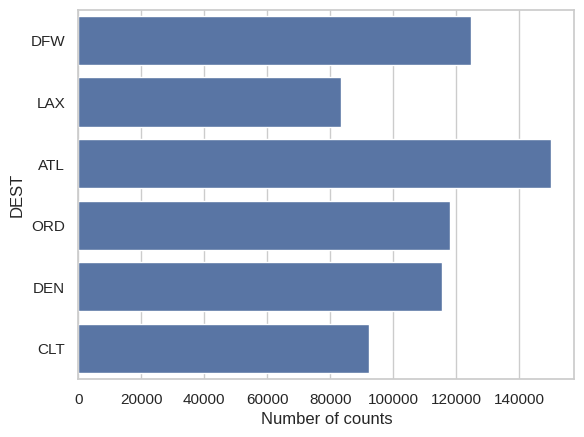

In [ ]:
# Output Barplot showing the occurence of each categorical features

sb.set_context("notebook")
g=sb.countplot(y="DEST",data=df_category)
g.set(xlabel="Number of counts")

In [ ]:
# Assuming df is your DataFrame containing the FL_DATE column
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Extracting Year, Quarter, Month, and DayofMonth into separate columns
df['Year'] = df['FL_DATE'].dt.year
df['Quarter'] = df['FL_DATE'].dt.quarter
df['Month'] = df['FL_DATE'].dt.month
df['DayofMonth'] = df['FL_DATE'].dt.day

In [ ]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_OFF_elapse,WHEELS_ON_elapse,FLIGHT_STATUS,Year,Quarter,Month,DayofMonth
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",18:40:00,18:38:00,-2.0,15.0,18:53:00,20:26:00,14.0,2041,20:40:00,-1.0,0.0,0.0,181.0,182.0,153.0,985.0,15.0,14.0,0,2020,1,2,23
8,2023-02-12,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,590,IAH,"Houston, TX",LAX,"Los Angeles, CA",05:30:00,05:27:00,-3.0,11.0,05:38:00,06:58:00,8.0,717,07:06:00,-11.0,0.0,0.0,227.0,219.0,200.0,1379.0,11.0,8.0,0,2023,1,2,12
11,2020-07-31,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2107,RDU,"Raleigh/Durham, NC",DFW,"Dallas/Fort Worth, TX",12:07:00,12:01:00,-6.0,14.0,12:15:00,13:46:00,11.0,1358,13:57:00,-1.0,0.0,0.0,171.0,176.0,151.0,1061.0,14.0,11.0,0,2020,3,7,31
13,2019-11-20,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1065,BDL,"Hartford, CT",ATL,"Atlanta, GA",06:00:00,05:55:00,-5.0,15.0,06:10:00,08:02:00,6.0,840,08:08:00,-32.0,0.0,0.0,160.0,133.0,112.0,859.0,15.0,6.0,0,2019,4,11,20
16,2020-07-01,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1225,STT,"Charlotte Amalie, VI",ATL,"Atlanta, GA",16:15:00,16:13:00,-2.0,15.0,16:28:00,19:45:00,3.0,1957,19:48:00,-9.0,0.0,0.0,222.0,215.0,197.0,1599.0,15.0,3.0,0,2020,3,7,1


encoding& feature selection

In [ ]:
# libraries
import warnings
# import findspark
import pandas as pd
import seaborn as sb
from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
from pyspark.ml.feature import Bucketizer
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import year, quarter

import numpy as np
import matplotlib.pyplot as plt

import datetime, warnings, scipy
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)